# Load and save DataFrames

We do not cover all features of the packages. Please refer to their documentation to learn them.

- https://github.com/ExpandingMan/Arrow.jl
- https://github.com/invenia/JLSO.jl
- https://github.com/JuliaData/JSONTables.jl
- https://github.com/xiaodaigh/JDF.jl

Here we'll load `CSV.jl` to read and write CSV files and `Arrow.jl`, `JLSO.jl`, and serialization, which allow us to work with a binary format and `JSONTables.jl` for JSON interaction. Finally we consider a custom `JDF.jl` format.

In [1]:
using DataFrames
using Arrow
using CSV
using Serialization
using JLSO
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots ## for charts
using Mmap ## for compression

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


Let's create a simple `DataFrame` for testing purposes,

In [2]:
x = DataFrame(
    A=[true, false, true], B=[1, 2, missing],
    C=[missing, "b", "c"], D=['a', missing, 'c']
)

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

and use `eltypes` to look at the columnwise types.

In [3]:
eltype.(eachcol(x))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

## CSV.jl
Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [4]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [5]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back.

In [6]:
y = CSV.read("x1.csv", DataFrame)

3×4 DataFrame
 Row │ A      B        C         D        
     │ Bool   Int64?   String1?  String1? 
─────┼────────────────────────────────────
   1 │  true        1  missing   a
   2 │ false        2  b         missing  
   3 │  true  missing  c         c

Note that when loading in a `DataFrame` from a `CSV` the column type for columns `:C` `:D` have changed to use special strings defined in the InlineStrings.jl package.

In [7]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String1}
 Union{Missing, String1}

## Serialization by JDF.jl and JLSO.jl

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process _will not work_ if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [8]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognise the content as DataFrames.jl

In [9]:
y = open(deserialize, "x.bin")

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [10]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### JDF.jl

`JDF.jl` is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.

For more details about design assumptions and limitations of `JDF.jl` please check out https://github.com/xiaodaigh/JDF.jl.

In [11]:
JDF.save("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [12]:
x_loaded = JDF.load("x.jdf") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

You can see that they are the same

In [13]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files

In [14]:
# set up a JDFFile which is a on disk representation of `x` backed by JDF.jl
x_ondisk = jdf"x.jdf"

JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [15]:
names(x_ondisk)

4-element Vector{Symbol}:
 :A
 :B
 :C
 :D

The below is an example of how to load only columns `:A` and `:D`

In [16]:
xd = JDF.load(x_ondisk; cols=["A", "D"]) |> DataFrame

3×2 DataFrame
 Row │ A      D       
     │ Bool   Char?   
─────┼────────────────
   1 │  true  a
   2 │ false  missing 
   3 │  true  c

### JLSO.jl
Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [17]:
JLSO.save("x.jlso", :data => x)

Now we can load back the file to `y`

In [18]:
y = JLSO.load("x.jlso")[:data]

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [19]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

## JSONTables.jl
Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [20]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [21]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [22]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [23]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [24]:
y1 = open(jsontable, "x1.json") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  String? 
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [25]:
eltype.(eachcol(y1))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

In [26]:
y2 = open(jsontable, "x2.json") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  String? 
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [27]:
eltype.(eachcol(y2))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

## Arrow.jl
Finally we use Apache Arrow format that allows, in particular, for data interchange with R or Python.

In [28]:
Arrow.write("x.arrow", x)

"x.arrow"

In [29]:
y = Arrow.Table("x.arrow") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [30]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

Note that columns of `y` are immutable

In [31]:
try
    y.A[1] = false
catch e
    show(e)
end

ReadOnlyMemoryError()

This is because `Arrow.Table` uses memory mapping and thus uses a custom vector types:

In [32]:
y.A

3-element Arrow.BoolVector{Bool}:
 1
 0
 1

In [33]:
y.B

3-element Arrow.Primitive{Union{Missing, Int64}, Vector{Int64}}:
 1
 2
  missing

You can get standard Julia Base vectors by copying a data frame

In [34]:
y2 = copy(y)

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [35]:
y2.A

3-element Vector{Bool}:
 1
 0
 1

In [36]:
y2.B

3-element Vector{Union{Missing, Int64}}:
 1
 2
  missing

## Basic bechmarking

Next, we'll create some files, so be careful that you don't already have these files in your working directory!

In particular, we'll time how long it takes us to write a `DataFrame` with 1000 rows and 100000 columns.

In [37]:
bigdf = DataFrame(rand(Bool, 10^4, 1000), :auto)

bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")

println("First run")

First run


In [38]:
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite1 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite2 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

CSV.jl


  4.520346 seconds (44.60 M allocations: 1.126 GiB, 4.27% gc time, 63.40% compilation time)
Serialization
  0.179294 seconds (148.06 k allocations: 9.352 MiB, 26.73% compilation time)


JDF.jl


  0.095084 seconds (46.82 k allocations: 147.657 MiB, 11.32% gc time, 111.51% compilation time)
JLSO.jl


  1.029119 seconds (174.96 k allocations: 14.867 MiB, 5.98% compilation time)
Arrow.jl


  3.256308 seconds (3.02 M allocations: 208.636 MiB, 1.15% gc time, 96.99% compilation time)
JSONTables.jl arraytable
 11.686247 seconds (229.61 M allocations: 5.423 GiB, 11.29% gc time, 0.07% compilation time)


JSONTables.jl objecttable


  0.372464 seconds (60.98 k allocations: 308.136 MiB, 35.64% gc time, 18.88% compilation time)
Second run
CSV.jl
  1.618924 seconds (44.40 M allocations: 1.113 GiB, 12.99% gc time)


Serialization


  0.141854 seconds (14.32 k allocations: 397.188 KiB, 5.90% compilation time)
JDF.jl


  0.081677 seconds (28.12 k allocations: 146.393 MiB, 9.51% gc time)
JLSO.jl


  0.968076 seconds (30.11 k allocations: 4.701 MiB)
Arrow.jl


  0.098084 seconds (52.79 k allocations: 5.619 MiB)
JSONTables.jl arraytable
 11.693286 seconds (229.61 M allocations: 5.423 GiB, 10.47% gc time, 0.07% compilation time)


JSONTables.jl objecttable


  0.337134 seconds (15.94 k allocations: 305.186 MiB, 38.97% gc time, 2.39% compilation time)


0.337387923

Exclude JSONTables.jl arraytable due to timing

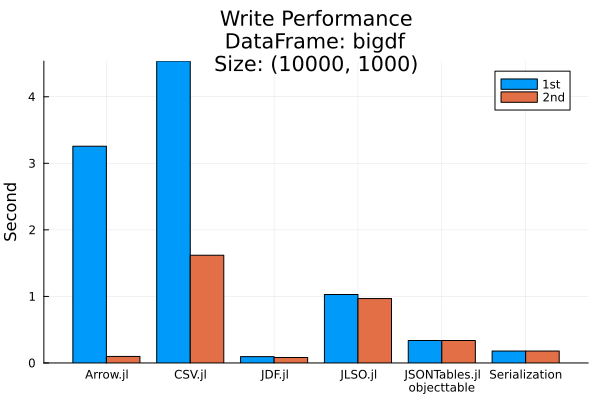

In [39]:
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "JSONTables.jl\nobjecttable"],
        inner=2),
    [csvwrite1, csvwrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2,
        jlsowrite1, jlsowrite2, arrowwrite1, arrowwrite2, jsontablesowrite2, jsontablesowrite2],
    group=repeat(["1st", "2nd"], outer=6),
    ylab="Second",
    title="Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [40]:
data_files = ["bigdf1.csv", "bigdf.bin", "bigdf.arrow", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file=data_files, size=getfield.(stat.(data_files), :size))
append!(df, DataFrame(file="bigdf.jdf", size=reduce((x, y) -> x + y.size,
    stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))),
    init=0)))
sort!(df, :size)

6×2 DataFrame
 Row │ file         size      
     │ String       Int64     
─────┼────────────────────────
   1 │ bigdf.arrow    1742770
   2 │ bigdf.bin      5201790
   3 │ bigdf.jdf      5222771
   4 │ bigdf1.csv    55085173
   5 │ bigdf2.json   55089174
   6 │ bigdf1.json  124030281

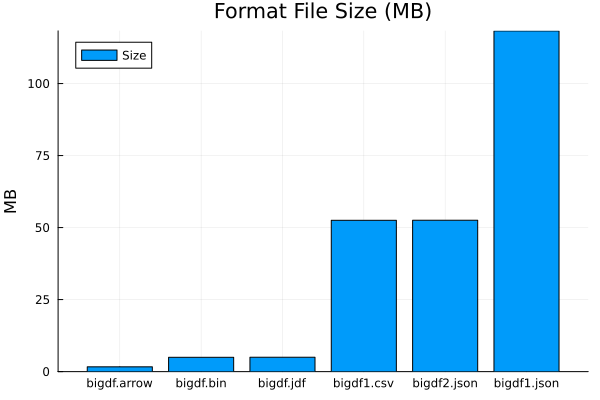

In [41]:
@df df plot(:file, :size / 1024^2, seriestype=:bar, title="Format File Size (MB)", label="Size", ylab="MB")

In [42]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread1 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread1copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread2 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread2copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl


  1.979127 seconds (1.93 M allocations: 155.763 MiB, 0.96% gc time, 244.67% compilation time)
Serialization
  0.433973 seconds (9.49 M allocations: 155.130 MiB, 10.95% gc time, 5.89% compilation time)


JDF.jl


  0.180052 seconds (123.89 k allocations: 161.520 MiB, 122.57% compilation time)
JLSO.jl


  0.359403 seconds (9.50 M allocations: 157.726 MiB, 7.37% gc time, 5.84% compilation time)
Arrow.jl


  0.363759 seconds (347.75 k allocations: 22.543 MiB, 98.50% compilation time)
  0.053692 seconds (12.50 k allocations: 10.319 MiB)
JSONTables.jl arraytable


 13.347633 seconds (30.24 M allocations: 2.530 GiB, 4.69% gc time)
JSONTables.jl objecttable
  0.347721 seconds (7.05 k allocations: 282.602 MiB, 5.33% gc time, 0.04% compilation time)


Second run


  0.392585 seconds (160.96 k allocations: 35.388 MiB)
Serialization
  0.399444 seconds (9.48 M allocations: 154.650 MiB, 6.76% gc time)


JDF.jl
  0.039274 seconds (69.69 k allocations: 157.945 MiB)
JLSO.jl


  0.336919 seconds (9.50 M allocations: 157.323 MiB)
Arrow.jl
  0.004663 seconds (67.53 k allocations: 3.292 MiB)
  0.053299 seconds (12.50 k allocations: 10.319 MiB)


JSONTables.jl arraytable


 12.999409 seconds (30.24 M allocations: 2.530 GiB, 2.74% gc time)
JSONTables.jl objecttable
  0.328286 seconds (6.06 k allocations: 282.532 MiB, 2.58% gc time)


Exclude JSON arraytable due to much longer timing

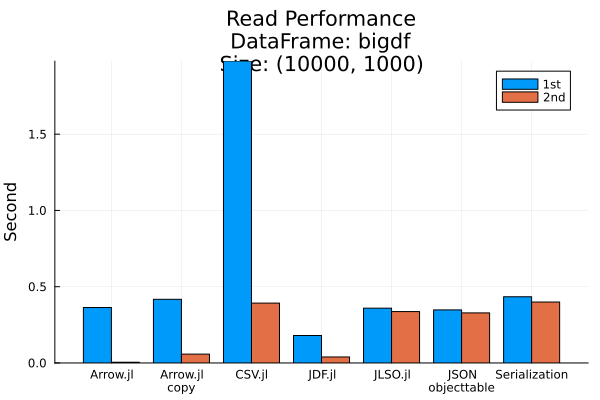

In [43]:
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "Arrow.jl\ncopy", #"JSON\narraytable",
            "JSON\nobjecttable"], inner=2),
    [csvread1, csvread2, serializeread1, serializeread2, jdfread1, jdfread2, jlsoread1, jlsoread2,
        arrowread1, arrowread2, arrowread1 + arrowread1copy, arrowread2 + arrowread2copy,
        # jsontablesaread1, jsontablesaread2,
        jsontablesoread1, jsontablesoread2],
    group=repeat(["1st", "2nd"], outer=7),
    ylab="Second",
    title="Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

## Using gzip compression
A common user requirement is to be able to load and save CSV that are compressed using gzip. Below we show how this can be accomplished using `CodecZlib.jl`. The same pattern is applicable to `JSONTables.jl` compression/decompression.

Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory.

We first generate a random data frame.

In [44]:
df = DataFrame(rand(1:10, 10, 1000), :auto)

10×1000 DataFrame
 Row │ x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x ⋯
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1      2      8     10      3      2      6      8      8      8    ⋯
   2 │     8      1      4      7     10     10      2      1      4      7
   3 │    10      3      2      6      4      3      3      3     10      7
   4 │     5      2     10      1      1      3      4      6      5      5
   5 │     2     10      9      6      2      8      4      3      6      9    ⋯
   6 │     4      6     10      9      4      6      8      2      9      4
   7 │    10      9      9      3      4      9      9      7      9      7
   8 │    10      3      1      2      6      7      3      9      5     10
   9 │     9      5      3      4      1     10      3      9      5      9    ⋯
  10 │     7      9      5      4      7      9      5      1      1      2
                                                             990 columns omitted

In [45]:
# GzipCompressorStream comes from CodecZlib
open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [46]:
df2 = CSV.File(transcode(GzipDecompressor, Mmap.mmap("df_compress_test.csv.gz"))) |> DataFrame

10×1000 DataFrame
 Row │ x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x ⋯
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1      2      8     10      3      2      6      8      8      8    ⋯
   2 │     8      1      4      7     10     10      2      1      4      7
   3 │    10      3      2      6      4      3      3      3     10      7
   4 │     5      2     10      1      1      3      4      6      5      5
   5 │     2     10      9      6      2      8      4      3      6      9    ⋯
   6 │     4      6     10      9      4      6      8      2      9      4
   7 │    10      9      9      3      4      9      9      7      9      7
   8 │    10      3      1      2      6      7      3      9      5     10
   9 │     9      5      3      4      1     10      3      9      5      9    ⋯
  10 │     7      9      5      4      7      9      5      1      1      2
                                                             990 columns omitted

In [47]:
df == df2

true

## Using zip files

Sometimes you may have files compressed inside a zip file.

In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.

Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [48]:
df1 = DataFrame(rand(1:10, 3, 4), :auto)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     8      3      6      1
   2 │     6      3      9      1
   3 │     5      4      6      6

In [49]:
df2 = DataFrame(rand(1:10, 3, 4), :auto)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     6      3      4      1
   2 │     9      2      3      7
   3 │    10      3      2      1

And we show yet another way to write a `DataFrame` into a CSV file:
writing a CSV file into the zip file

In [50]:
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the CSV we have written:

In [51]:
z = ZipFile.Reader("x.zip");

In [52]:
# find the index index of file called x1.csv
index_xcsv = findfirst(x -> x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     8      3      6      1
   2 │     6      3      9      1
   3 │     5      4      6      6

In [53]:
df1_2 == df1

true

In [54]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x -> x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     6      3      4      1
   2 │     9      2      3      7
   3 │    10      3      2      1

In [55]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (it is at its end). Therefore to read it again you need to close `z` and open it again.

Also do not forget to close the zip file once done.

In [56]:
close(z)